<h1>SPY TLT Dynamic Allocation</h1>

<p>Last updated 04/09/2020</p>
<p>Since we are experiencing a huge drawdown in the SP 500 I thought it would be a good opportunity to play around with a strategy that does well in market drawdowns (ie. SPY-TLT Allocation). Here instead of SPY I will be using IVV, which is basically the same. I will experiment with SPYTLT Allocations that are daily rebalancin & fully invested.</p>

In [1]:
#libraries I will be using
import json
import smtplib

import numpy as np
import pandas as pd
import quantstats as qs
import yahoofinancials as yf

from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import exp_cov
from pypfopt.expected_returns import prices_from_returns

from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.utils import COMMASPACE, formatdate
from datetime import datetime, timedelta, date

from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

In [2]:
#some functions I might need
def daterange(start_date, end_date):
    ''' 
    daterange(date(2005, 12, 31), date(2020, 3, 25))
    creates range between 2 dates given
    '''
    for n in range(int ((end_date - start_date).days)):
        yield pd.to_datetime(start_date + timedelta(n))

def get_hist_prices(symbol, start_date, end_date, time_interval):
    '''
    get_historical_prices('TLT', '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
    uses yahoo financials to download stock prices monthly, weekly or daily
    '''
    obj = yf.YahooFinancials(symbol)
    data = obj.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
    df = pd.DataFrame(data[symbol]['prices'])
    df = df.rename(columns={'formatted_date':'Date'})
    df = df.set_index(df['Date'], drop=True)
    
    try:
        divs = pd.DataFrame(data[symbol]['eventsData']['dividends']).T
        divs = divs.rename(columns={'formatted_date':'Date','amount':'dividend'})
        divs = divs.set_index(divs['Date'],drop=True)
        df = df.merge(divs['dividend'],left_index=True,right_index=True,how='outer')
        df['dividend'] = df['dividend'].fillna(0)
        df['log_div_return']=np.log(df['adjclose']/(df['adjclose']-df['dividend']))
        df['div_return'] = (df['dividend'])/df['adjclose'].shift(1)
    except:
        pass
    
    try:
        df['log_total_return']=np.log(df['adjclose']/df['adjclose'].shift(1))  
        df['log_price_return']=np.log(df['close']/df['close'].shift(1))
        df['total_return'] = (df['adjclose']-df['adjclose'].shift(1))/df['adjclose'].shift(1)
        df['price_return']= (df['close']-df['close'].shift(1))/df['close'].shift(1)
        df['1M_Vol'] = df['log_price_return'].rolling(21).std() * np.sqrt(251)
        df['3M_Vol'] = df['log_price_return'].rolling(63).std() * np.sqrt(251)
        df['1M_Return'] = df['log_total_return'].rolling(21).sum()
        df['3M_Return'] = df['log_total_return'].rolling(63).sum()
    except:
        pass

    df = df.add_suffix('_'+symbol) 
    return df

def get_list_hist_price(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['close_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

def get_list_hist_price_returns(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['price_return_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

def get_list_hist_total_returns(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['log_total_return_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

In [3]:
#Getting prices
ivv_tlt_prices = get_list_hist_price(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_prices = ivv_tlt_prices.dropna()
ivv_tlt_prices = (ivv_tlt_prices / ivv_tlt_prices.iloc[0] -1) 

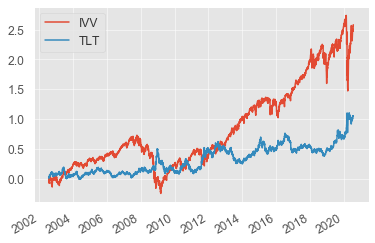

In [4]:
#plotting prices
ivv_tlt_prices.plot()

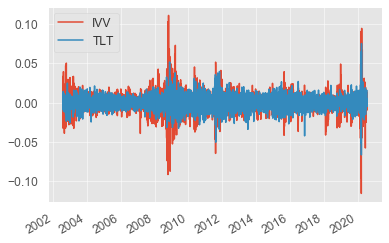

In [5]:
ivv_tlt_price_returns = get_list_hist_price_returns(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_price_returns = ivv_tlt_price_returns.dropna()
ivv_tlt_price_returns.plot()

<p>As far as price returns it seems like SPY is a better investment from a return perspective</p>

In [6]:
ivv_tlt_total_returns = get_list_hist_total_returns(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_total_returns = ivv_tlt_total_returns.add_suffix('_Return')

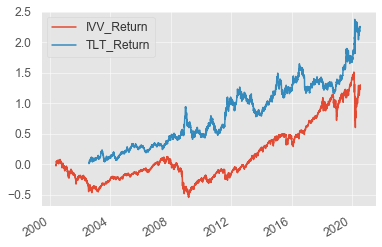

In [7]:
((ivv_tlt_total_returns[['IVV_Return','TLT_Return']] + 1).cumprod(skipna=True)-1).plot()

<h1>Final Portfolio</h1>
<h2>Minimum Variance Portfolio with a Exp. Covariance Matrix Span = 77</h2>

In [51]:
dates = daterange(date(2013, 12, 31), date(2020, 7, 21))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
    cov = exp_cov(prices,span=77,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0],cov_matrix=cov, weight_bounds=(0, .90)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']

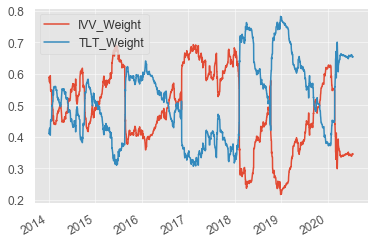

In [52]:
weights_total_returns[['IVV_Weight','TLT_Weight']].plot()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2020-07-20  2020-07-20
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          92.14%      80.2%
CAGR%                      10.48%      9.41%
Sharpe                     1.27        0.59
Sortino                    1.73        0.8
Max Drawdown               -15.78%     -36.12%
Longest DD Days            415         383
Volatility (ann.)          8.13%       17.96%
R^2                        0.21        0.21
Calmar                     0.66        0.26
Skew                       -1.56       -1.05
Kurtosis                   17.69       22.18

Expected Daily %           0.04%       0.04%
Expected Monthly %         0.83%       0.75%
Expected Yearly %          9.78%       8.78%
Kelly Criterion            9.02%       2.58%
Risk of Ruin               0.0%      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-09,2020-03-18,2020-04-29,51,-15.776696,-14.193210
2,2015-03-23,2015-08-25,2016-04-06,380,-8.565987,-8.222447
3,2018-01-29,2018-11-02,2019-03-20,415,-7.817105,-7.196627
4,2016-08-01,2016-11-14,2017-04-24,266,-6.937893,-6.745249
5,2020-02-21,2020-02-27,2020-03-06,14,-4.601335,-3.806885


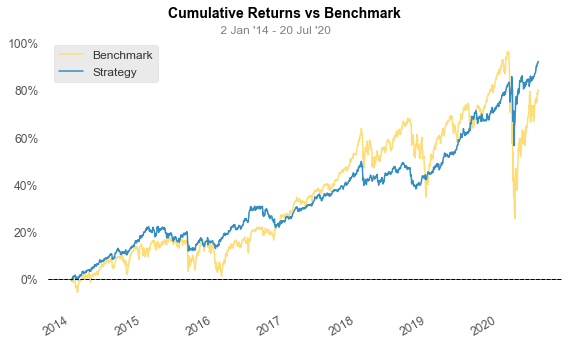

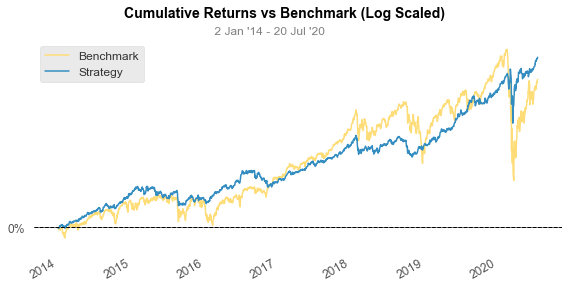

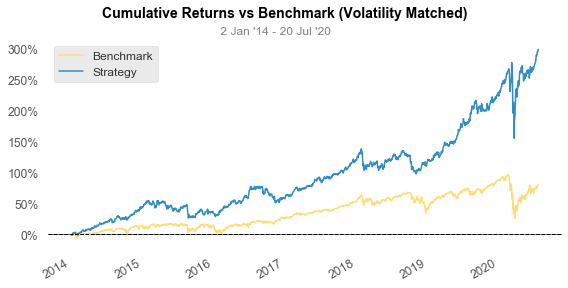

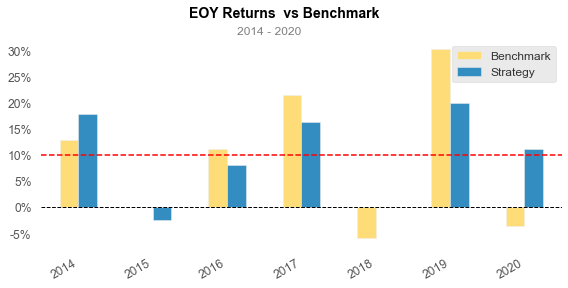

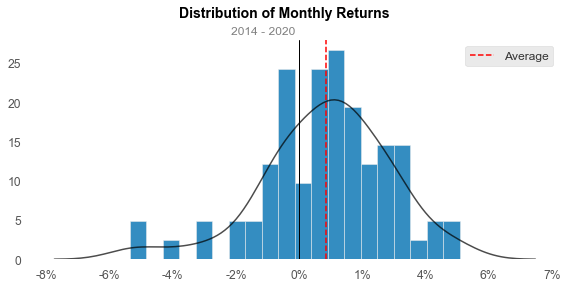

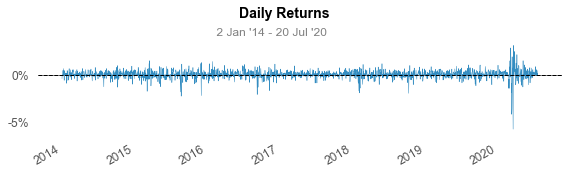

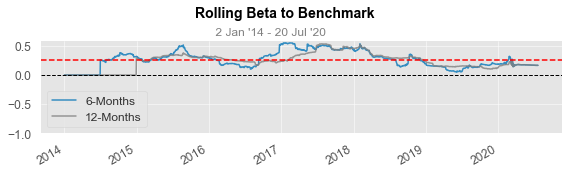

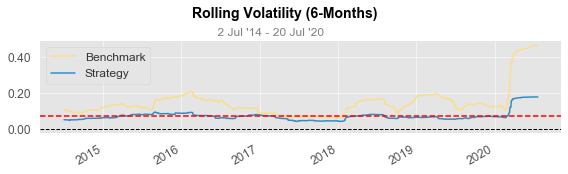

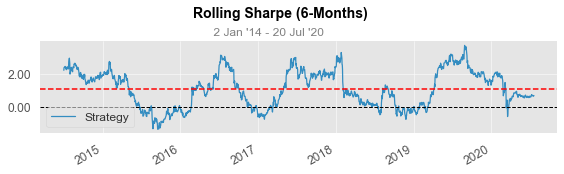

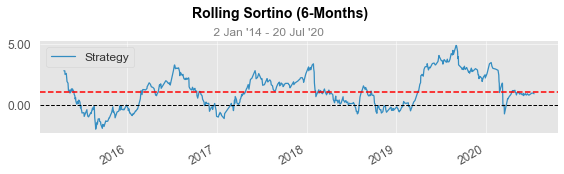

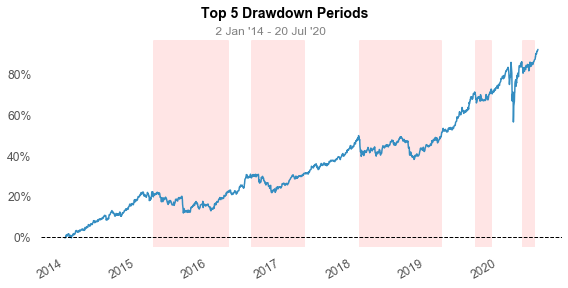

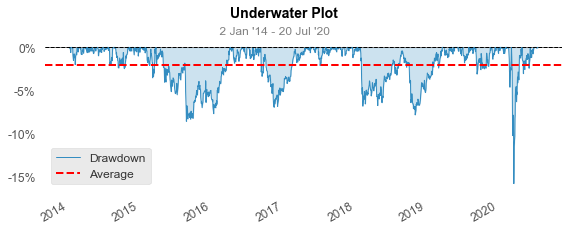

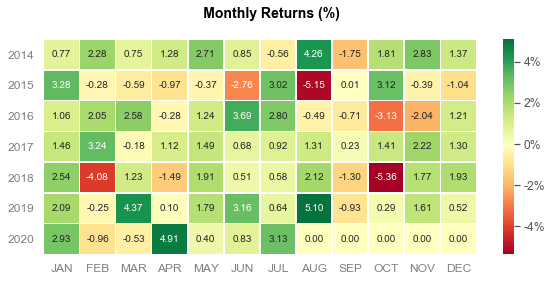

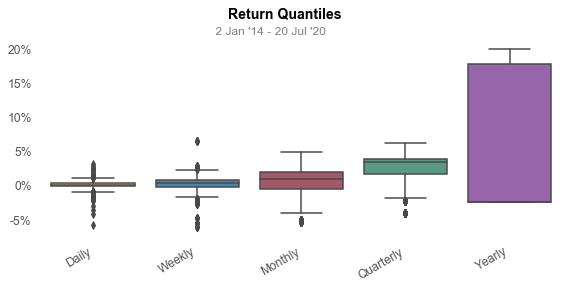

In [53]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['IVV_Return'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2020-07-20  2020-07-20
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          92.14%      81.29%
CAGR%                      10.48%      9.51%
Sharpe                     1.27        0.73
Sortino                    1.73        1.05
Max Drawdown               -15.78%     -18.29%
Longest DD Days            415         1116
Volatility (ann.)          8.13%       13.8%
R^2                        0.3         0.3
Calmar                     0.66        0.52
Skew                       -1.56       -0.03
Kurtosis                   17.69       9.76

Expected Daily %           0.04%       0.04%
Expected Monthly %         0.83%       0.76%
Expected Yearly %          9.78%       8.87%
Kelly Criterion            12.21%      -0.03%
Risk of Ruin               0.0%     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-09,2020-03-18,2020-04-29,51,-15.776696,-14.193210
2,2015-03-23,2015-08-25,2016-04-06,380,-8.565987,-8.222447
3,2018-01-29,2018-11-02,2019-03-20,415,-7.817105,-7.196627
4,2016-08-01,2016-11-14,2017-04-24,266,-6.937893,-6.745249
5,2020-02-21,2020-02-27,2020-03-06,14,-4.601335,-3.806885


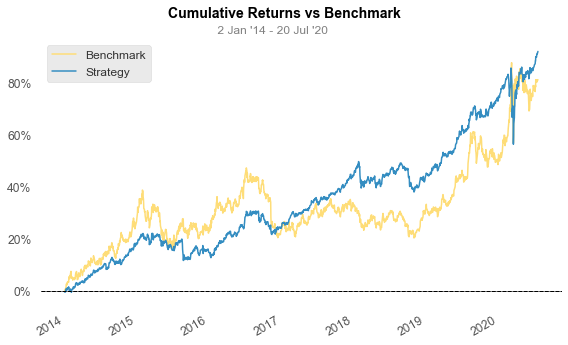

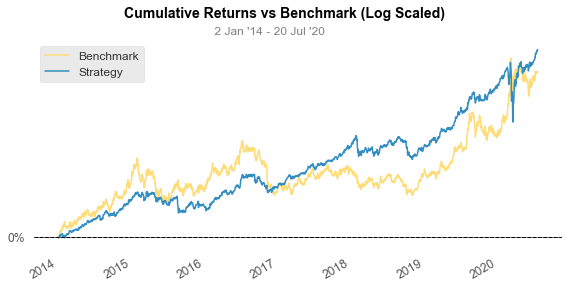

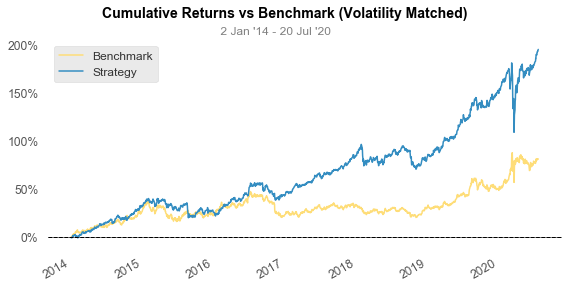

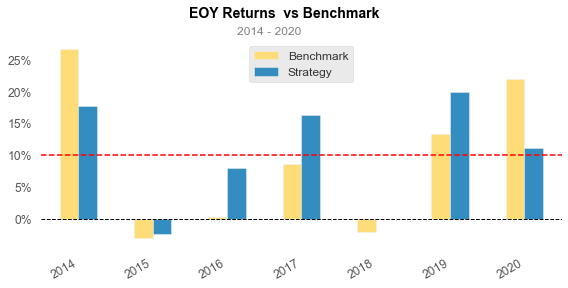

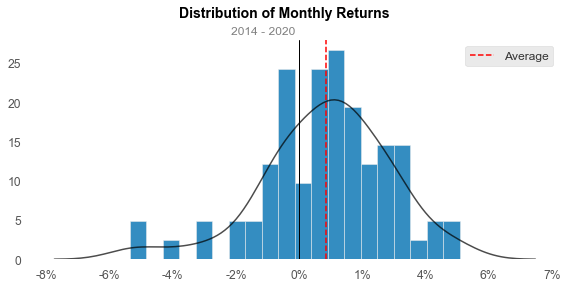

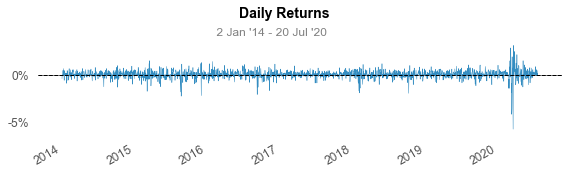

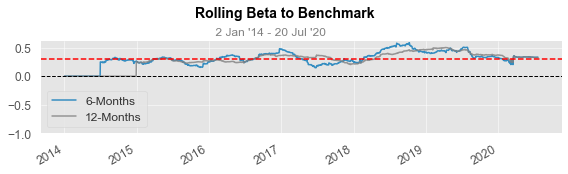

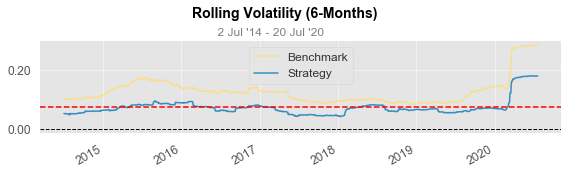

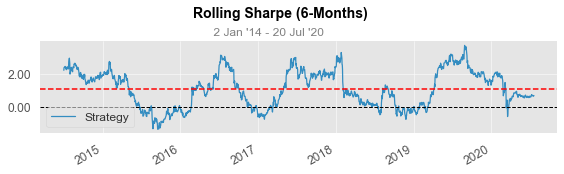

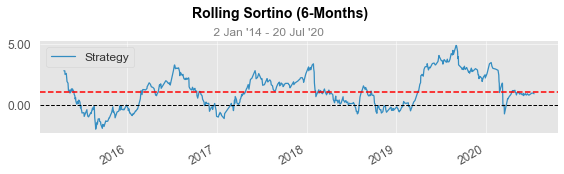

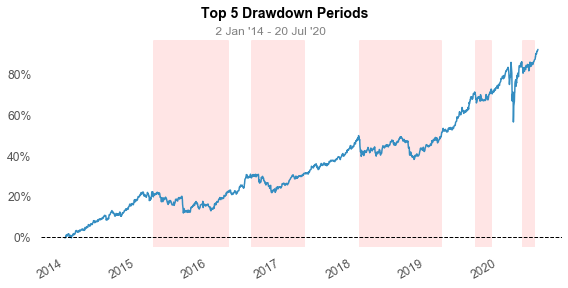

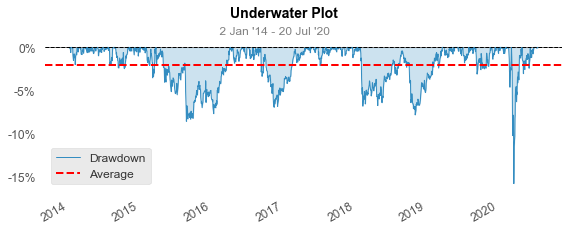

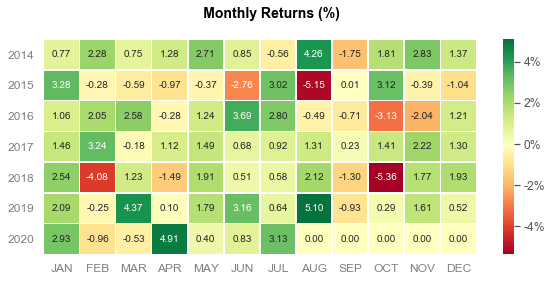

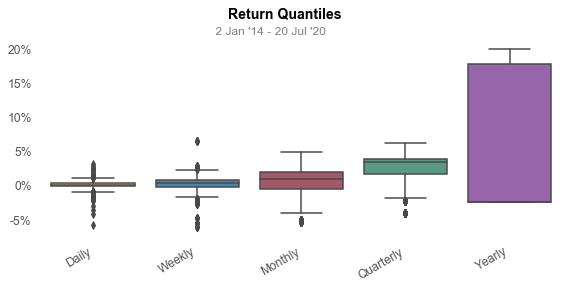

In [54]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['TLT_Return'])

In [13]:
bench = weights_total_returns.copy()

In [14]:
#Getting prices
tickers=['IVW','IVE','TLT']
all_prices = get_list_hist_price(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_prices = all_prices.dropna()
all_prices = (all_prices / all_prices.iloc[0] -1) 
all_price_returns = get_list_hist_price_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_price_returns = all_price_returns.dropna()
all_total_returns = get_list_hist_total_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_total_returns = all_total_returns.add_suffix('_Return')

In [15]:
dates = daterange(date(2003, 12, 31), date(2020, 7, 21))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(all_price_returns[all_price_returns.index<d])
    cov = exp_cov(prices,span=77,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0,0],cov_matrix=cov, weight_bounds=(0, .90)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = all_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = 0
for ticker in tickers:
    weights_total_returns['Portfolio_Return'] = weights_total_returns['Portfolio_Return'] + weights_total_returns[ticker+'_Return'] * weights_total_returns[ticker+'_Weight'] 

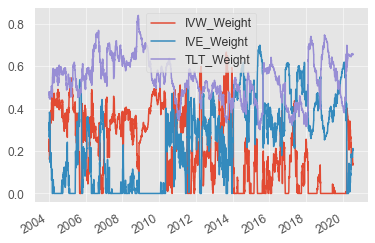

In [16]:
fig, ax = plt.subplots()
for ticker in tickers:
    weights_total_returns[[ticker+'_Weight']].plot(ax=ax)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-02  2004-01-02
End Period                 2020-07-20  2020-07-20
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          252.31%     278.75%
CAGR%                      7.9%        8.37%
Sharpe                     0.97        1.02
Sortino                    1.38        1.44
Max Drawdown               -17.81%     -19.2%
Longest DD Days            622         630
Volatility (ann.)          8.16%       8.27%
R^2                        0.97        0.97
Calmar                     0.44        0.44
Skew                       -0.55       -0.58
Kurtosis                   7.88        8.48

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.63%       0.67%
Expected Yearly %          7.69%       8.15%
Kelly Criterion            7.95%       8.87%
Risk of Ruin               0.0%      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-05-27,2010-09-14,622,-17.805155,-16.560799
2,2020-03-09,2020-03-18,2020-04-24,46,-16.000766,-14.445563
3,2007-12-04,2008-11-13,2008-12-04,366,-12.665072,-12.165504
4,2015-02-03,2015-08-25,2016-06-03,486,-10.347743,-10.028452
5,2018-01-29,2018-11-02,2019-03-28,423,-8.681714,-8.213222


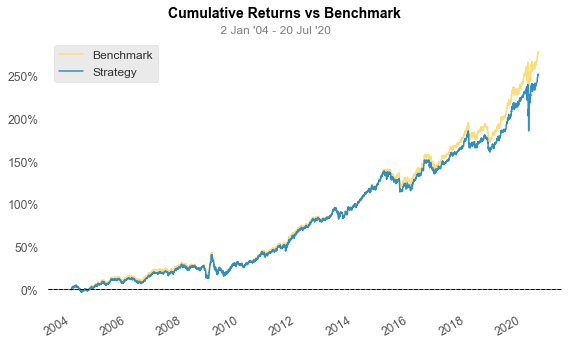

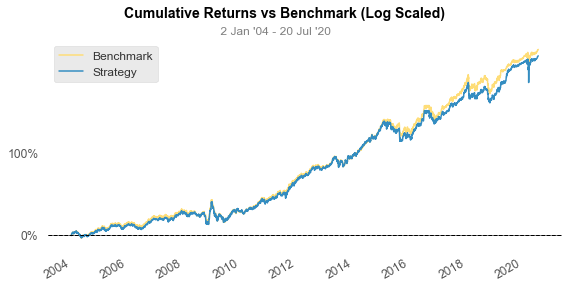

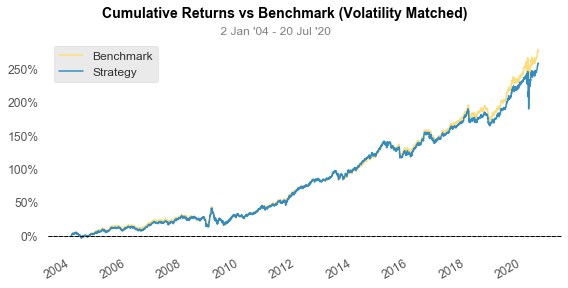

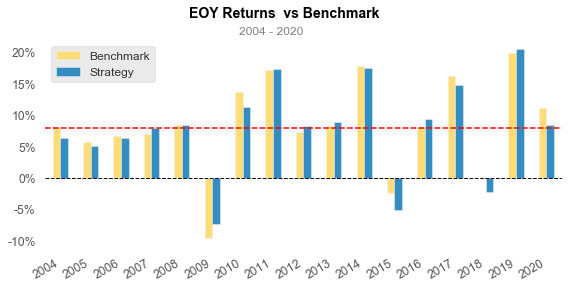

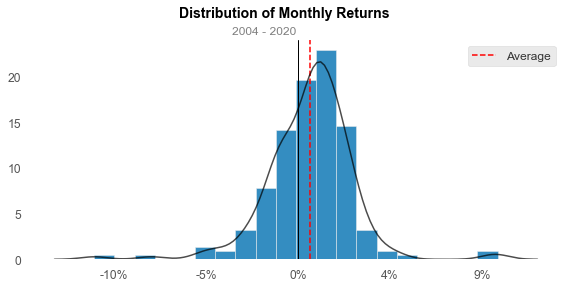

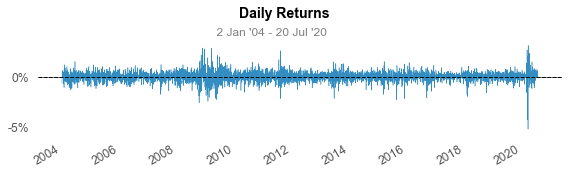

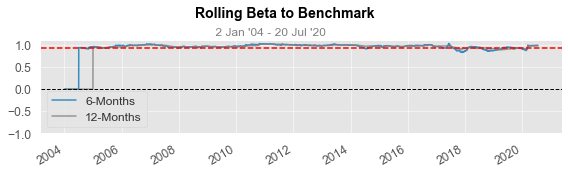

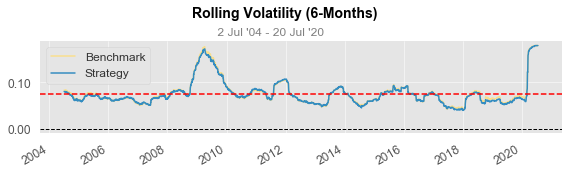

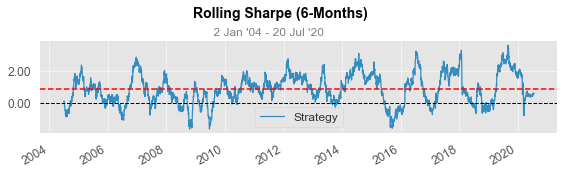

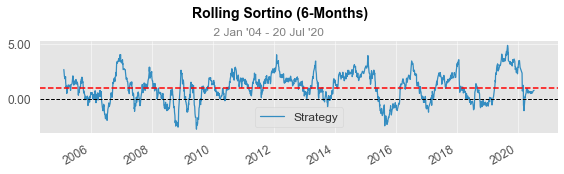

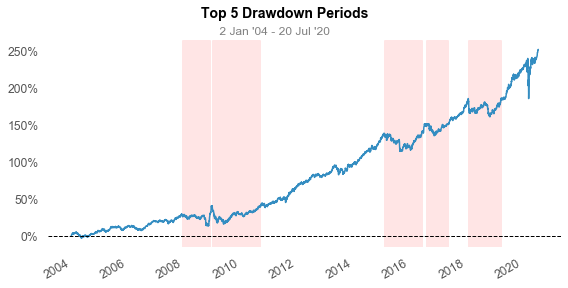

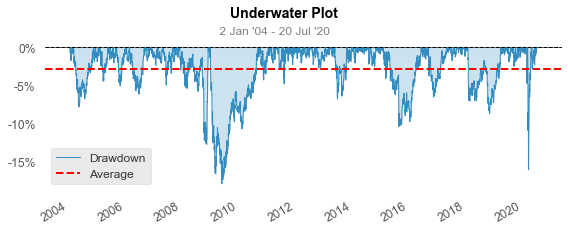

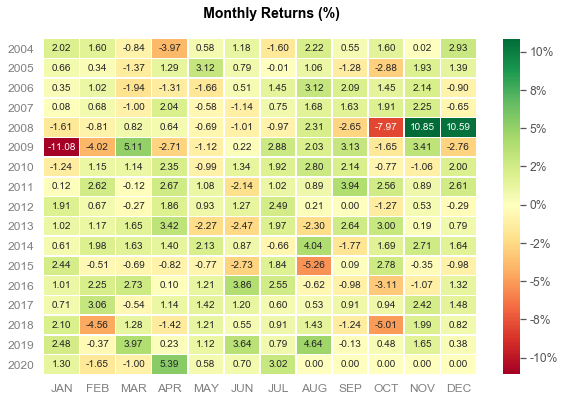

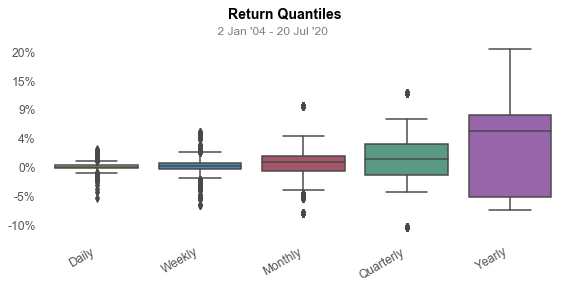

In [18]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=bench['Portfolio_Return'])

In [23]:
#Getting prices
tickers=['QUAL','MTUM','VLUE','SIZE','TLT']
all_prices = get_list_hist_price(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_prices = all_prices.dropna()
all_prices = (all_prices / all_prices.iloc[0] -1) 
all_prices.head()

,QUAL,MTUM,VLUE,SIZE,TLT
2013-07-18,0.000000,0.000000,0.000000,0.0000,0.000000
2013-07-19,-0.007777,0.004435,-0.001827,0.0000,0.015814
2013-07-22,-0.002991,0.005729,0.000914,0.0181,0.017302
2013-07-23,-0.004586,0.004066,0.000914,0.0181,0.013023
2013-07-24,-0.005982,0.000554,0.000914,0.0181,0.000186


In [24]:
all_price_returns = get_list_hist_price_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_price_returns = all_price_returns.dropna()
all_total_returns = get_list_hist_total_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_total_returns = all_total_returns.add_suffix('_Return')

In [26]:
dates = daterange(date(2013, 12, 31), date(2020, 7, 21))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(all_price_returns[all_price_returns.index<d])
    cov = exp_cov(prices,span=77,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0,0,0,0],cov_matrix=cov, weight_bounds=(0, .90)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = all_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = 0
for ticker in tickers:
    weights_total_returns['Portfolio_Return'] = weights_total_returns['Portfolio_Return'] + weights_total_returns[ticker+'_Return'] * weights_total_returns[ticker+'_Weight'] 

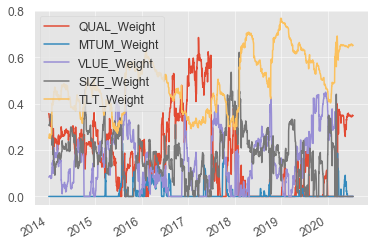

In [27]:
fig, ax = plt.subplots()
for ticker in tickers:
    weights_total_returns[[ticker+'_Weight']].plot(ax=ax)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2020-07-20  2020-07-20
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          75.01%      92.14%
CAGR%                      8.92%       10.48%
Sharpe                     1.1         1.27
Sortino                    1.47        1.73
Max Drawdown               -16.76%     -15.78%
Longest DD Days            438         415
Volatility (ann.)          8.11%       8.13%
R^2                        0.93        0.93
Calmar                     0.53        0.66
Skew                       -1.76       -1.56
Kurtosis                   19.75       17.69

Expected Daily %           0.03%       0.04%
Expected Monthly %         0.71%       0.83%
Expected Yearly %          8.32%       9.78%
Kelly Criterion            8.81%       11.88%
Risk of Ruin               0.0%   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-09,2020-03-18,2020-07-09,122,-16.759191,-15.093626
2,2015-03-23,2015-09-28,2016-06-03,438,-9.294300,-9.083591
3,2018-01-29,2018-11-02,2019-03-27,422,-8.441388,-7.964723
4,2016-08-01,2016-11-14,2017-05-19,291,-6.845017,-6.628223
5,2020-02-21,2020-02-27,2020-03-06,14,-4.401617,-3.450071


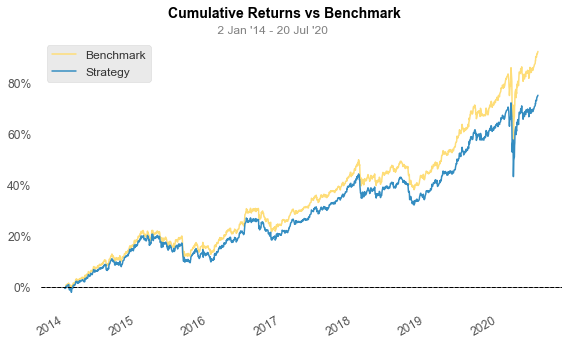

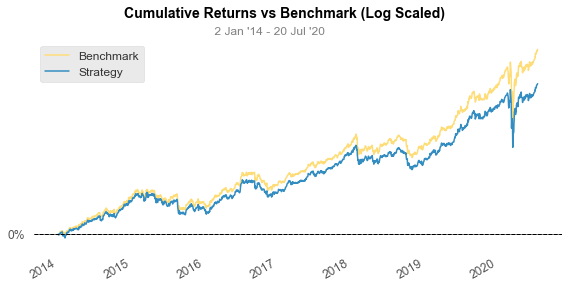

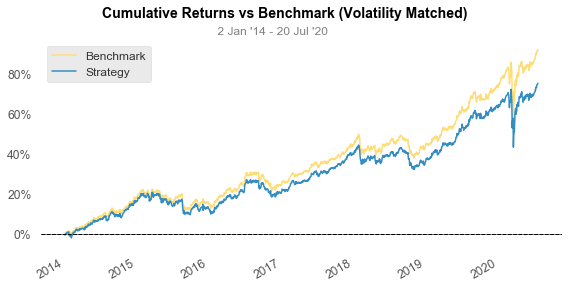

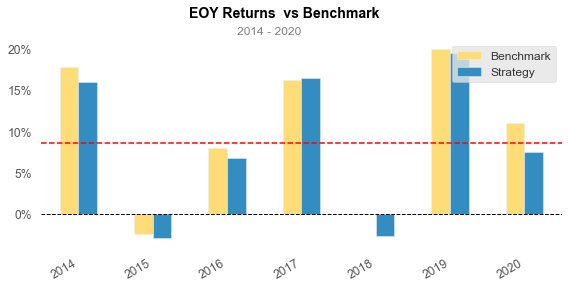

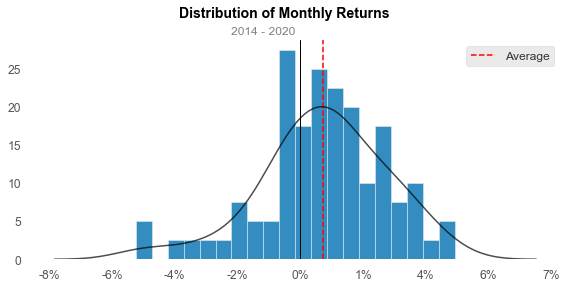

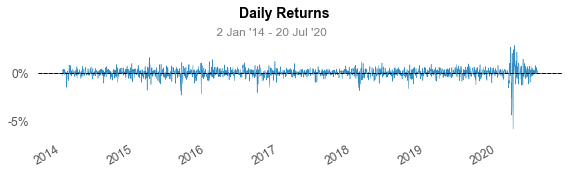

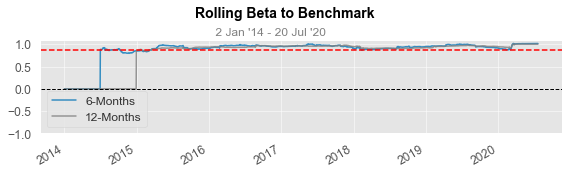

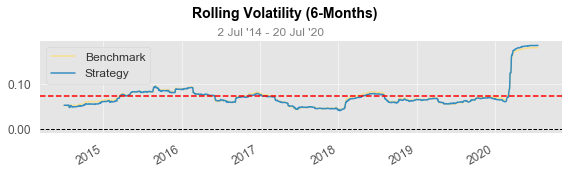

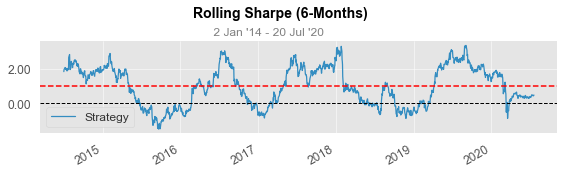

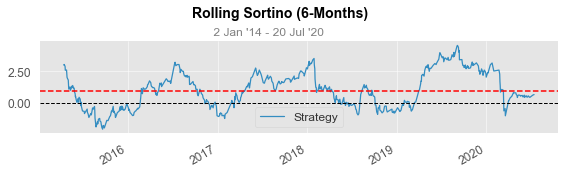

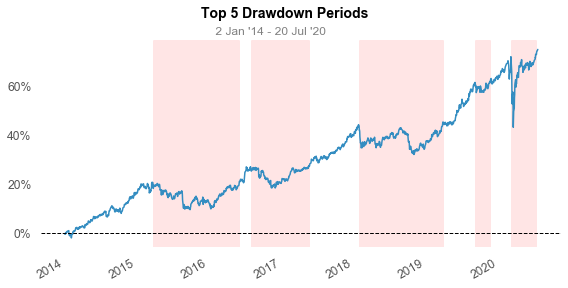

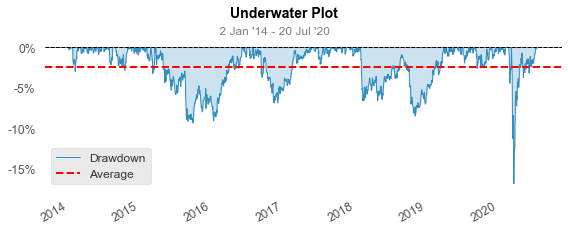

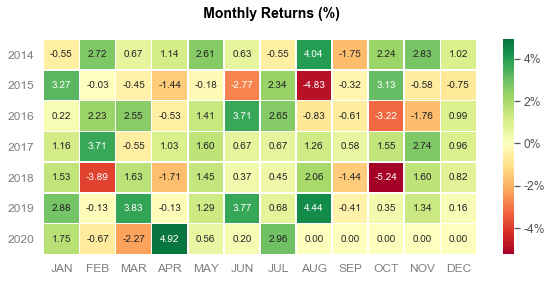

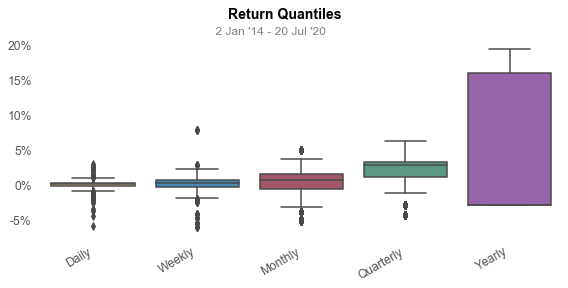

In [28]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=bench['Portfolio_Return'])

In [32]:
#Getting prices
tickers=['QUAL','MTUM','TLT']
all_prices = get_list_hist_price(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_prices = all_prices.dropna()
all_prices = (all_prices / all_prices.iloc[0] -1) 
all_prices.head()

,QUAL,MTUM,TLT
2013-07-18,0.000000,0.000000,0.000000
2013-07-19,-0.007777,0.004435,0.015814
2013-07-22,-0.002991,0.005729,0.017302
2013-07-23,-0.004586,0.004066,0.013023
2013-07-24,-0.005982,0.000554,0.000186


In [33]:
all_price_returns = get_list_hist_price_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_price_returns = all_price_returns.dropna()
all_total_returns = get_list_hist_total_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_total_returns = all_total_returns.add_suffix('_Return')

In [34]:
dates = daterange(date(2013, 12, 31), date(2020, 7, 21))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(all_price_returns[all_price_returns.index<d])
    cov = exp_cov(prices,span=77,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0,0],cov_matrix=cov, weight_bounds=(0, .90)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = all_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = 0
for ticker in tickers:
    weights_total_returns['Portfolio_Return'] = weights_total_returns['Portfolio_Return'] + weights_total_returns[ticker+'_Return'] * weights_total_returns[ticker+'_Weight'] 

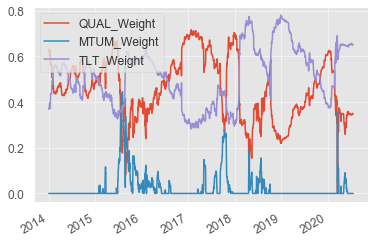

In [35]:
fig, ax = plt.subplots()
for ticker in tickers:
    weights_total_returns[[ticker+'_Weight']].plot(ax=ax)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2020-07-20  2020-07-20
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          92.4%       92.14%
CAGR%                      10.51%      10.48%
Sharpe                     1.26        1.27
Sortino                    1.72        1.73
Max Drawdown               -15.18%     -15.78%
Longest DD Days            416         415
Volatility (ann.)          8.19%       8.13%
R^2                        0.97        0.97
Calmar                     0.69        0.66
Skew                       -1.44       -1.56
Kurtosis                   15.07       17.69

Expected Daily %           0.04%       0.04%
Expected Monthly %         0.83%       0.83%
Expected Yearly %          9.8%        9.78%
Kelly Criterion            11.08%      11.19%
Risk of Ruin               0.0%   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-09,2020-03-18,2020-04-24,46,-15.181991,-13.919332
2,2018-01-29,2018-11-02,2019-03-21,416,-8.506834,-7.893643
3,2015-03-23,2015-08-25,2016-03-29,372,-8.297426,-7.663422
4,2016-07-11,2016-12-01,2017-05-16,309,-7.211351,-6.739846
5,2020-02-21,2020-02-27,2020-03-06,14,-4.259846,-3.402778


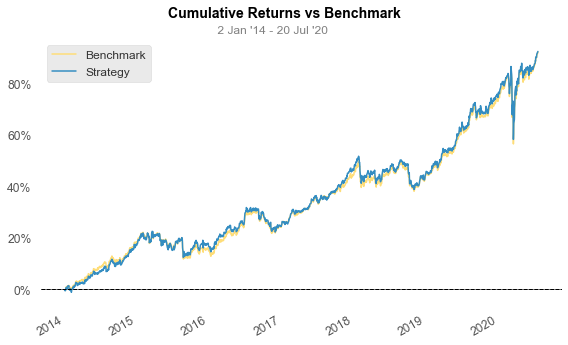

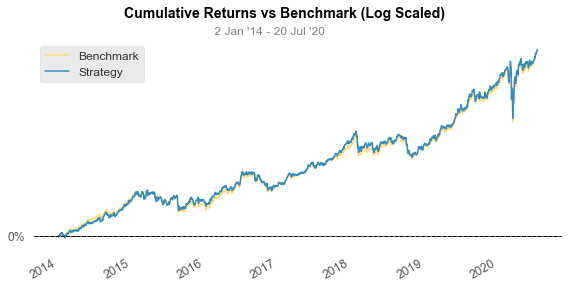

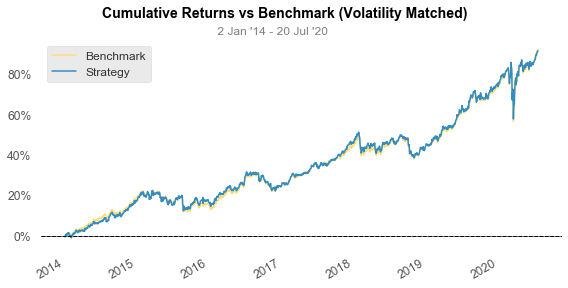

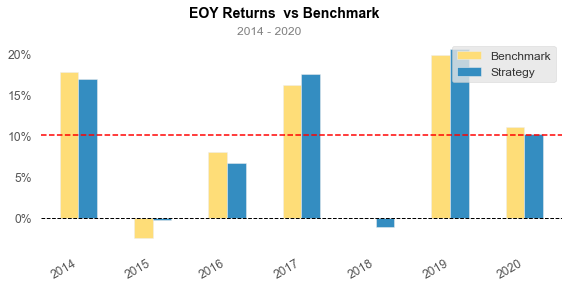

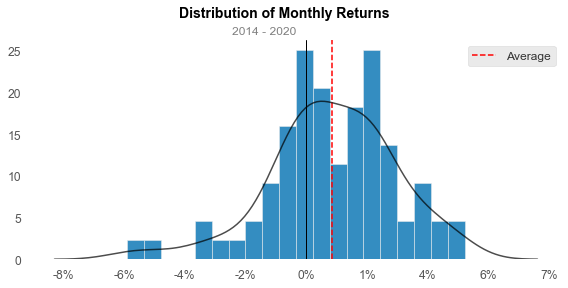

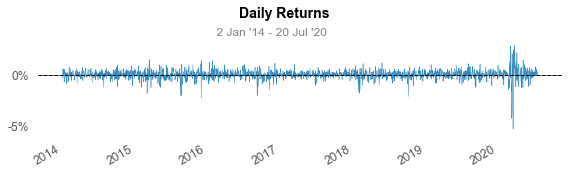

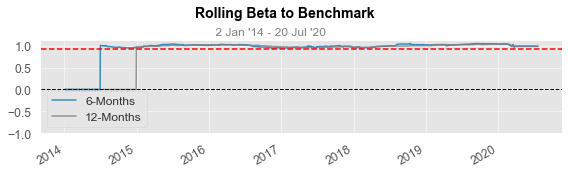

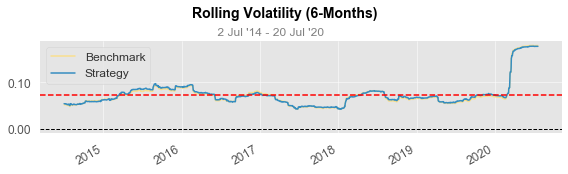

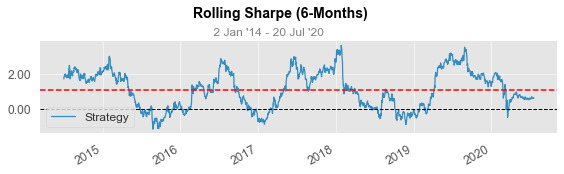

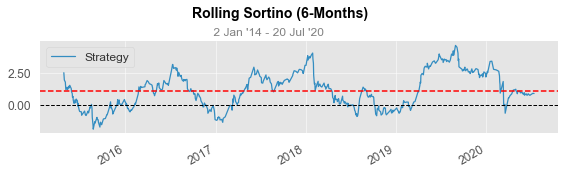

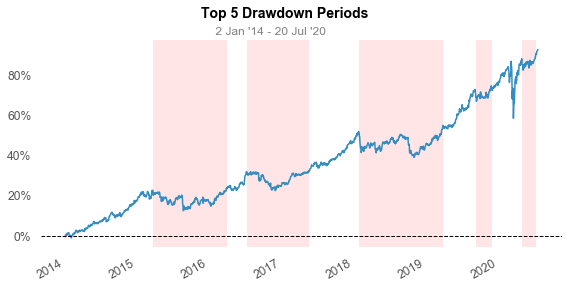

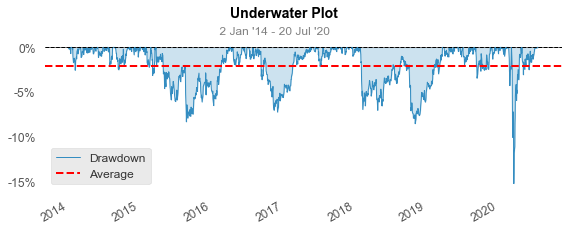

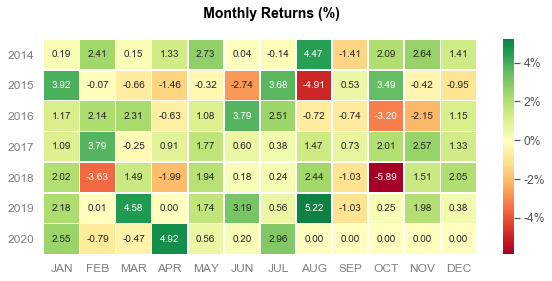

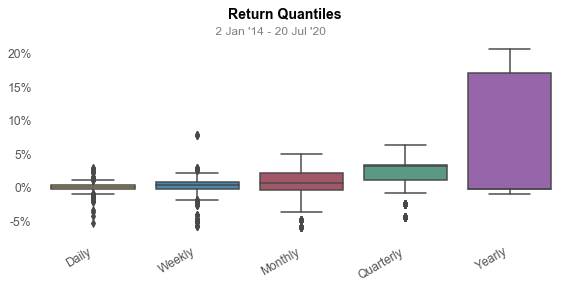

In [36]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=bench['Portfolio_Return'])

In [37]:
#Getting prices
tickers=['MTUM','TLT']
all_prices = get_list_hist_price(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_prices = all_prices.dropna()
all_prices = (all_prices / all_prices.iloc[0] -1) 
all_prices.head()

,MTUM,TLT
2013-04-18,0.000000,0.000000
2013-04-19,0.000000,-0.002112
2013-04-22,0.000000,-0.001381
2013-04-23,0.025530,-0.004874
2013-04-24,0.012569,-0.002356


In [38]:
all_price_returns = get_list_hist_price_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_price_returns = all_price_returns.dropna()
all_total_returns = get_list_hist_total_returns(tickers, '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
all_total_returns = all_total_returns.add_suffix('_Return')

In [46]:
dates = daterange(date(2013, 12, 31), date(2020, 7, 21))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(all_price_returns[all_price_returns.index<d])
    cov = exp_cov(prices,span=77,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0],cov_matrix=cov, weight_bounds=(0, .90)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = all_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = 0
for ticker in tickers:
    weights_total_returns['Portfolio_Return'] = weights_total_returns['Portfolio_Return'] + weights_total_returns[ticker+'_Return'] * weights_total_returns[ticker+'_Weight'] 

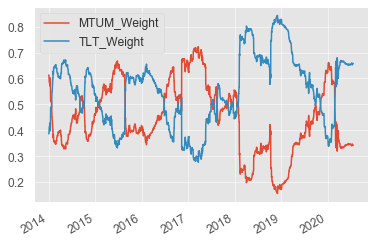

In [47]:
fig, ax = plt.subplots()
for ticker in tickers:
    weights_total_returns[[ticker+'_Weight']].plot(ax=ax)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2020-07-20  2020-07-20
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          92.14%      80.2%
CAGR%                      10.48%      9.41%
Sharpe                     1.27        0.59
Sortino                    1.73        0.8
Max Drawdown               -15.78%     -36.12%
Longest DD Days            415         383
Volatility (ann.)          8.13%       17.96%
R^2                        0.21        0.21
Calmar                     0.66        0.26
Skew                       -1.56       -1.05
Kurtosis                   17.69       22.18

Expected Daily %           0.04%       0.04%
Expected Monthly %         0.83%       0.75%
Expected Yearly %          9.78%       8.78%
Kelly Criterion            9.02%       2.58%
Risk of Ruin               0.0%      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-09,2020-03-18,2020-04-29,51,-15.776696,-14.193210
2,2015-03-23,2015-08-25,2016-04-06,380,-8.565987,-8.222447
3,2018-01-29,2018-11-02,2019-03-20,415,-7.817105,-7.196627
4,2016-08-01,2016-11-14,2017-04-24,266,-6.937893,-6.745249
5,2020-02-21,2020-02-27,2020-03-06,14,-4.601335,-3.806885


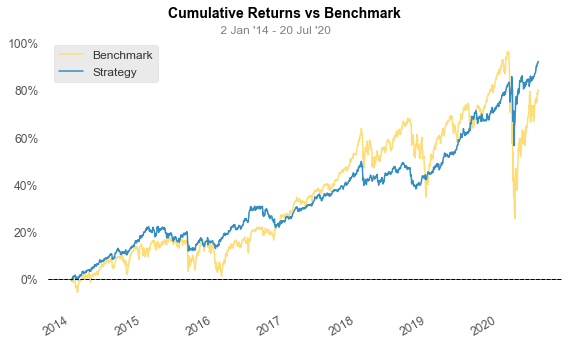

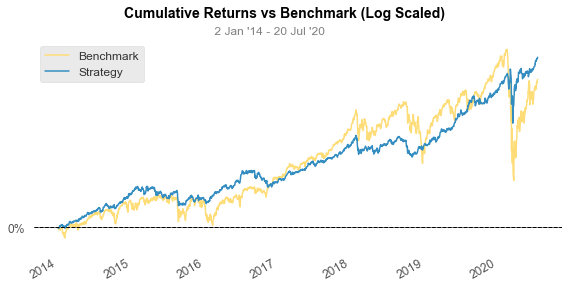

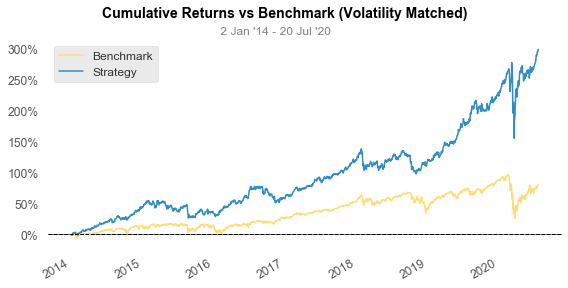

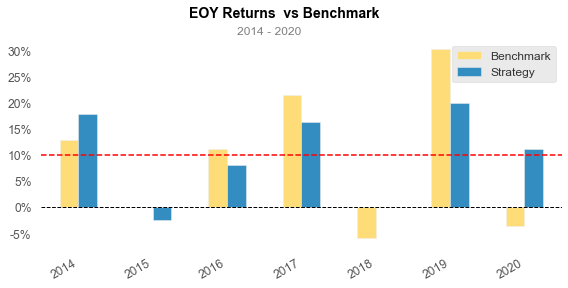

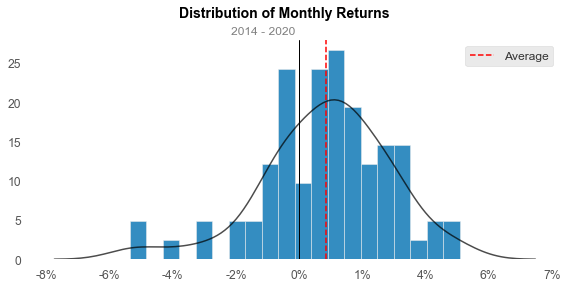

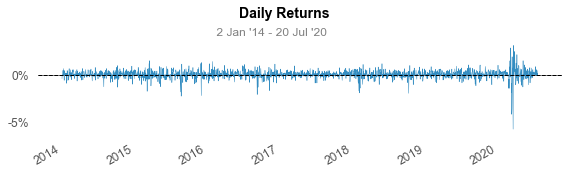

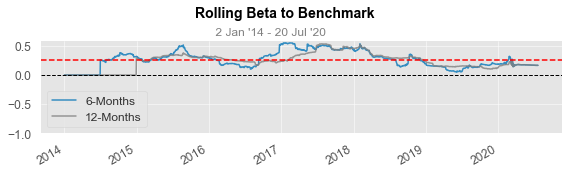

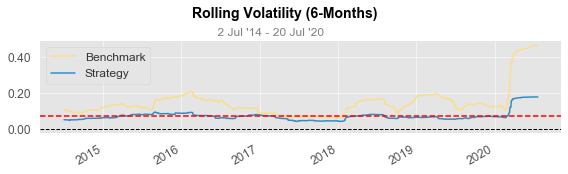

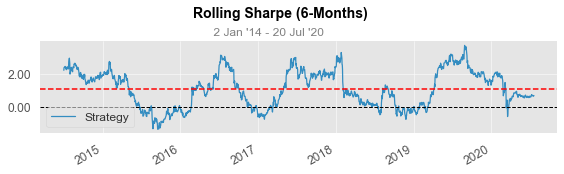

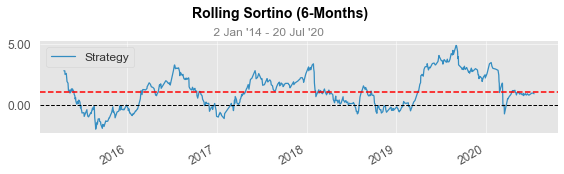

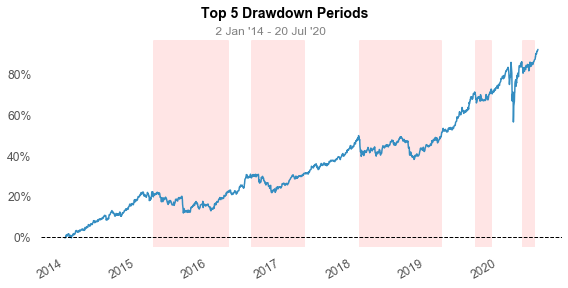

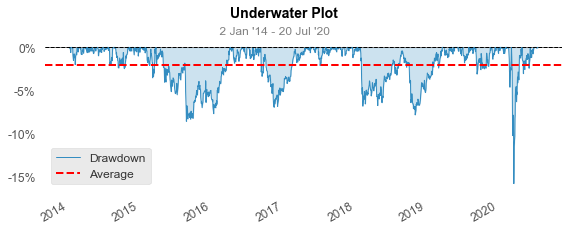

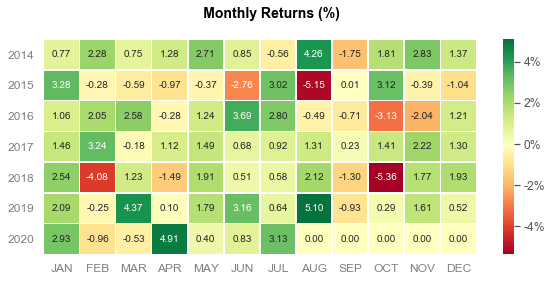

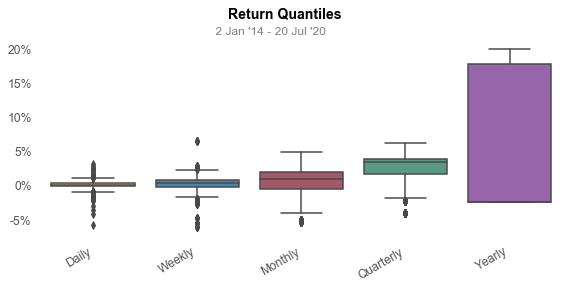

In [55]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=bench['IVV_Return'])